In [1]:
import torch
import numpy as np
import h5py 
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 250
from torch.utils.data import DataLoader
import sys 
model_path = "C:\\Users\\noedi\\Desktop\\Stage été 2022\\Code stage\\Vae Galaxies\\"
sys.path.append(model_path)

In [2]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [3]:
galaxy_denoised = 'C:\\Users\\noedi\\Desktop\\Stage été 2022\\Code Stage\\Vae galaxies\\Data\\cosmos.h5'
galaxy_w_redshift = 'C:\\Users\\noedi\\Desktop\\Stage été 2022\\Code Stage\\Vae galaxies\\Data\\cosmos_25.2_all_with_zphot.h5'

In [4]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, file):
        self.file = file
        self.hdf = h5py.File(file, 'r')

    def __len__(self):
        self.hdf.keys()
        return len(self.hdf["images"])
    
    def __getitem__(self, idx):
        with h5py.File(self.file, 'r') as hf:
            x = hf["images"][idx]
            z = hf["zphot"][idx]
        return x, z

In [5]:
galaxy_w_redshift_dataset = dataset(galaxy_w_redshift)
batchsize = 64
galaxy_loader = DataLoader(galaxy_w_redshift_dataset, batch_size = batchsize, shuffle = False)

In [6]:
data_size = len(galaxy_w_redshift_dataset)
train_size = int(0.9*(data_size))
val_size = data_size - train_size

In [7]:
train_set, val_set = torch.utils.data.random_split(galaxy_w_redshift_dataset, [train_size, val_size])

# Defining the model and loading the weights 

In [22]:
# Importing model
from CVAE_4_correct import VariationalAutoencoder

# Model parameters
nc, nf, z_dim = 2, 64, 32
vae = VariationalAutoencoder(nc, nf, z_dim).to(device)

# Loading trained weights 
weights_path = "C:\\Users\\noedi\\Desktop\\Stage été 2022\\Code stage\\Vae Galaxies\\Data\\weights + losses\\galaxy_w_redshift\\cvae\\test4corrected_z32_beta0.1_weights.pt"
vae.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

# Reconstruction

In [23]:
galaxies, zphot = next(iter(galaxy_loader))

In [24]:
def reconstruct_cvae_4(galaxies, zphot, cols = 10, colour = 'magma'):
    x_cond = vae.concatenate(galaxies, zphot).to(device)
    pred_galaxies, pred_z = vae.split(vae(x_cond))

    figure, axs = plt.subplots(2, cols, figsize = (8, 2))

    for j in range(cols):
        rdm_label = torch.randint(batchsize, size = (1,))
        axs[0,j].imshow(galaxies[rdm_label].squeeze(), cmap = colour)
        axs[0,j].axis("off")
        axs[0,j].annotate(f"{zphot[rdm_label].item():.2f}", xy=(0.6, 0.85), xycoords = 'axes fraction', color = 'white', fontsize = 7)
        axs[1,j].imshow(pred_galaxies[rdm_label].detach().to('cpu').numpy().squeeze(), cmap = 'magma')
        axs[1,j].axis('off')
        axs[1,j].annotate(f"{pred_z[rdm_label].item():.2f}", xy=(0.6, 0.85), xycoords = 'axes fraction', color = 'white', fontsize = 7)
    plt.subplots_adjust(wspace=0.1 , hspace= -0.3 )
    

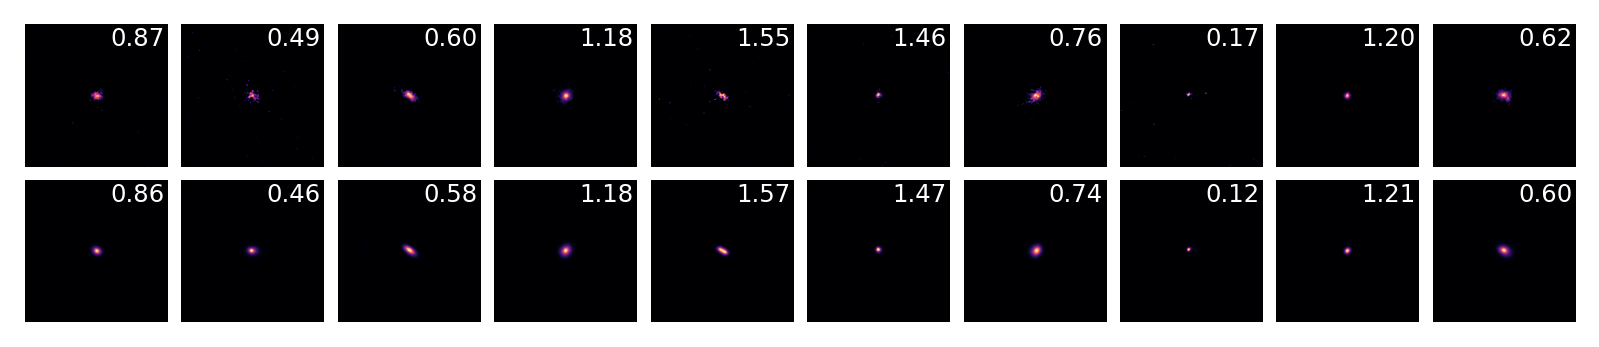

In [25]:

reconstruct_cvae_4(galaxies, zphot)


In [30]:
galaxy_loader = DataLoader(galaxy_w_redshift_dataset, batch_size = batchsize, shuffle = False)
galaxies, zphot = next(iter(galaxy_loader))

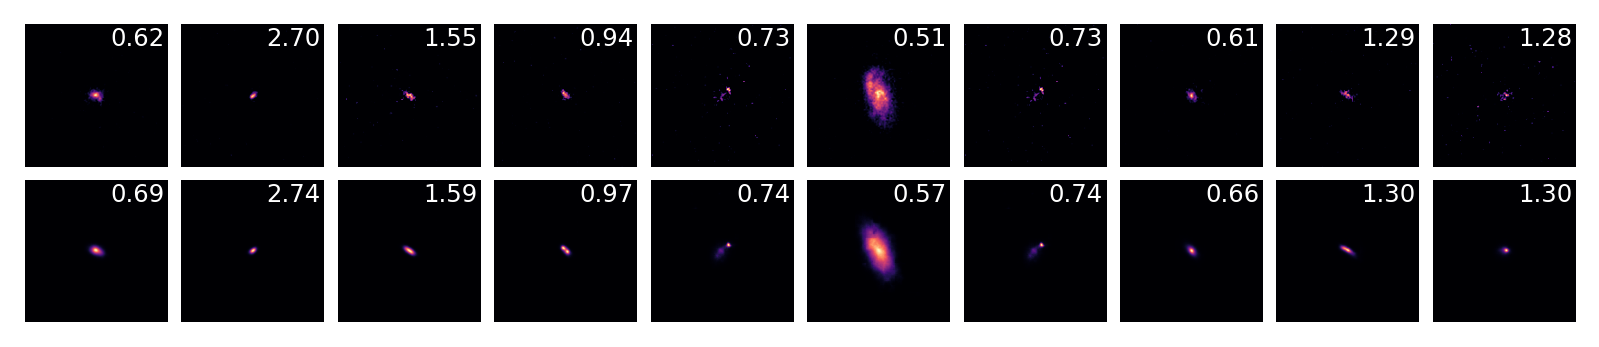

In [33]:
torch.manual_seed(0)

galaxies = galaxies.to(device)
zphot = zphot.to(device)
pred_galaxies, pred_z = vae(galaxies.unsqueeze(1), zphot.unsqueeze(1))

figure, axs = plt.subplots(2, 10, figsize = (8,2))
cols = 10

for j in range(cols):
    rdm_label = torch.randint(batchsize, size = (1,))
    axs[0,j].imshow(galaxies[rdm_label].detach().to('cpu').squeeze(), cmap = 'magma')
    axs[0,j].axis('off')
    axs[0,j].annotate(f"{zphot[rdm_label].item():.2f}", xy=(0.6, 0.85), xycoords = 'axes fraction', color = 'white', fontsize = 7)
    axs[1,j].imshow(pred_galaxies[rdm_label].detach().to('cpu').numpy().squeeze(), cmap = 'magma')
    axs[1,j].axis('off')
    axs[1,j].annotate(f"{pred_z[rdm_label].item():.2f}", xy=(0.6, 0.85), xycoords = 'axes fraction', color = 'white', fontsize = 7)
plt.subplots_adjust(wspace=0.1 , hspace= -0.3 )

#plt.savefig('C:\\Users\\noedi\\Desktop\\Reconstruction_CVAE1_beta0.1.jpeg')

# Generation

In [26]:
def generate_cvae_4(redshift_value, rows = 8, cols = 8, device = 'cuda', colour = 'magma'):
    """
    Generate a 8*8 grid of galaxy images based on the redshift value given in input representing a distribution of the images according to this redshift value.
    A latent space tensor sampled from a uniform multivariate normal distribution is concatenated to the redshift value along the channel dimension
    thanks to the function concatenate defined in the class vae = VariationalAutoencoder(nc, nf, z_dim)
    channel 0 = latent tensor (N, 1, z_dim)
    channel 1 = redshift values (N, 1, z_dim)
    input_concatenated = (N, 2, z_dim)
    Then, the concatenated tensor is fed to the decoder which outputs a prediction of the concatenated input. 
    The function split defined in the class vae, splits the concatenated output in two different tensors: 
    The prediction of the galaxy image and its associated predicted redshift value
    """
    if type(redshift_value) == torch.Tensor:
        redshift = redshift_value 
    else:
        redshift = torch.tensor([redshift_value]).to(device)
    figure, axs = plt.subplots(rows, cols, figsize = (10,10))
    for i in range(rows):
        for j in range(cols):
            z_generated = torch.normal(0, 1, size = (1,1, z_dim)).to(device)
            generated_galaxies, pred_redshift = vae.split(vae.decoder(vae.concatenate(z_generated, redshift)))
            axs[i,j].imshow(generated_galaxies.detach().to('cpu').numpy().squeeze(), cmap = colour)
            axs[i,j].axis('off')
            axs[i,j].annotate(f"{pred_redshift.item():.2f}", xy = (0.75, 0.85), xycoords = "axes fraction", color = 'white', fontsize = 6)
            axs[i,j].annotate(f"{redshift_value:.2f}", xy =(0.1, 0.85) , xycoords = "axes fraction", color = 'white', fontsize = 6 )
    plt.subplots_adjust(wspace = 0.1, hspace = -0.1)

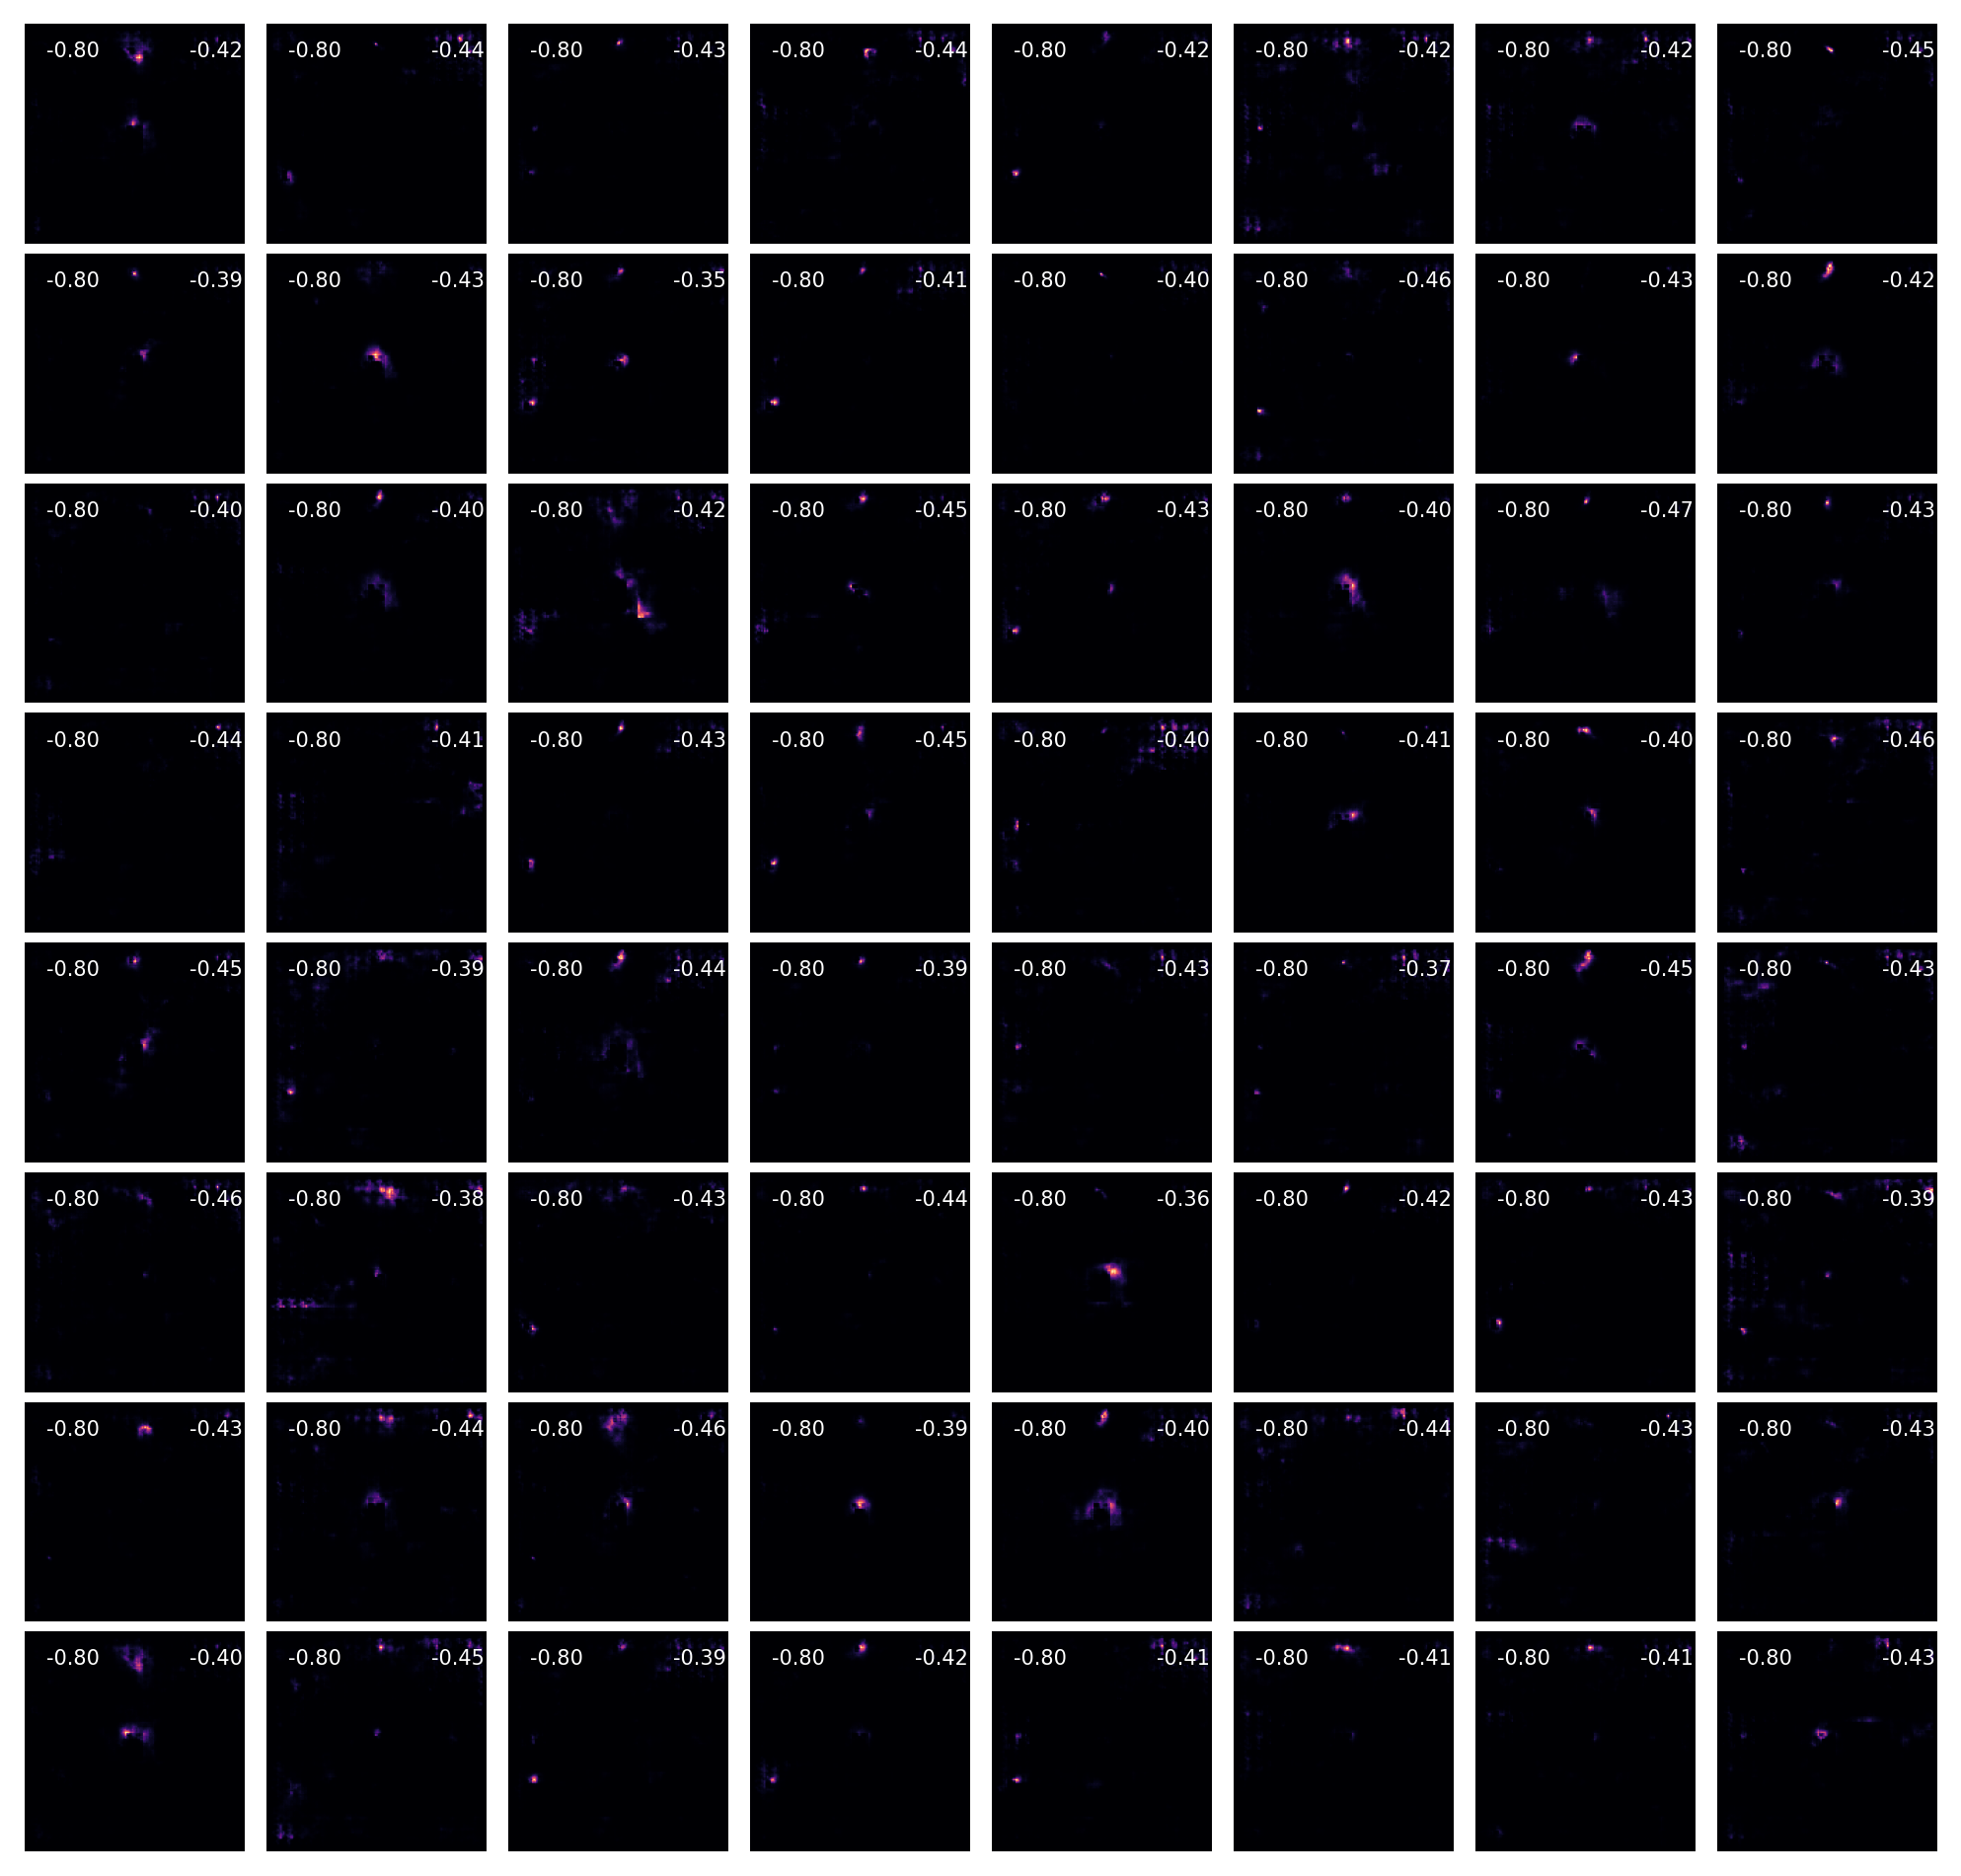

In [28]:
torch.manual_seed(0)
generate_cvae_4(-0.8)
#plt.savefig("C:\\Users\\noedi\\Desktop\\Generation_CVAE4_beta0.1_rs0.1.jpeg")

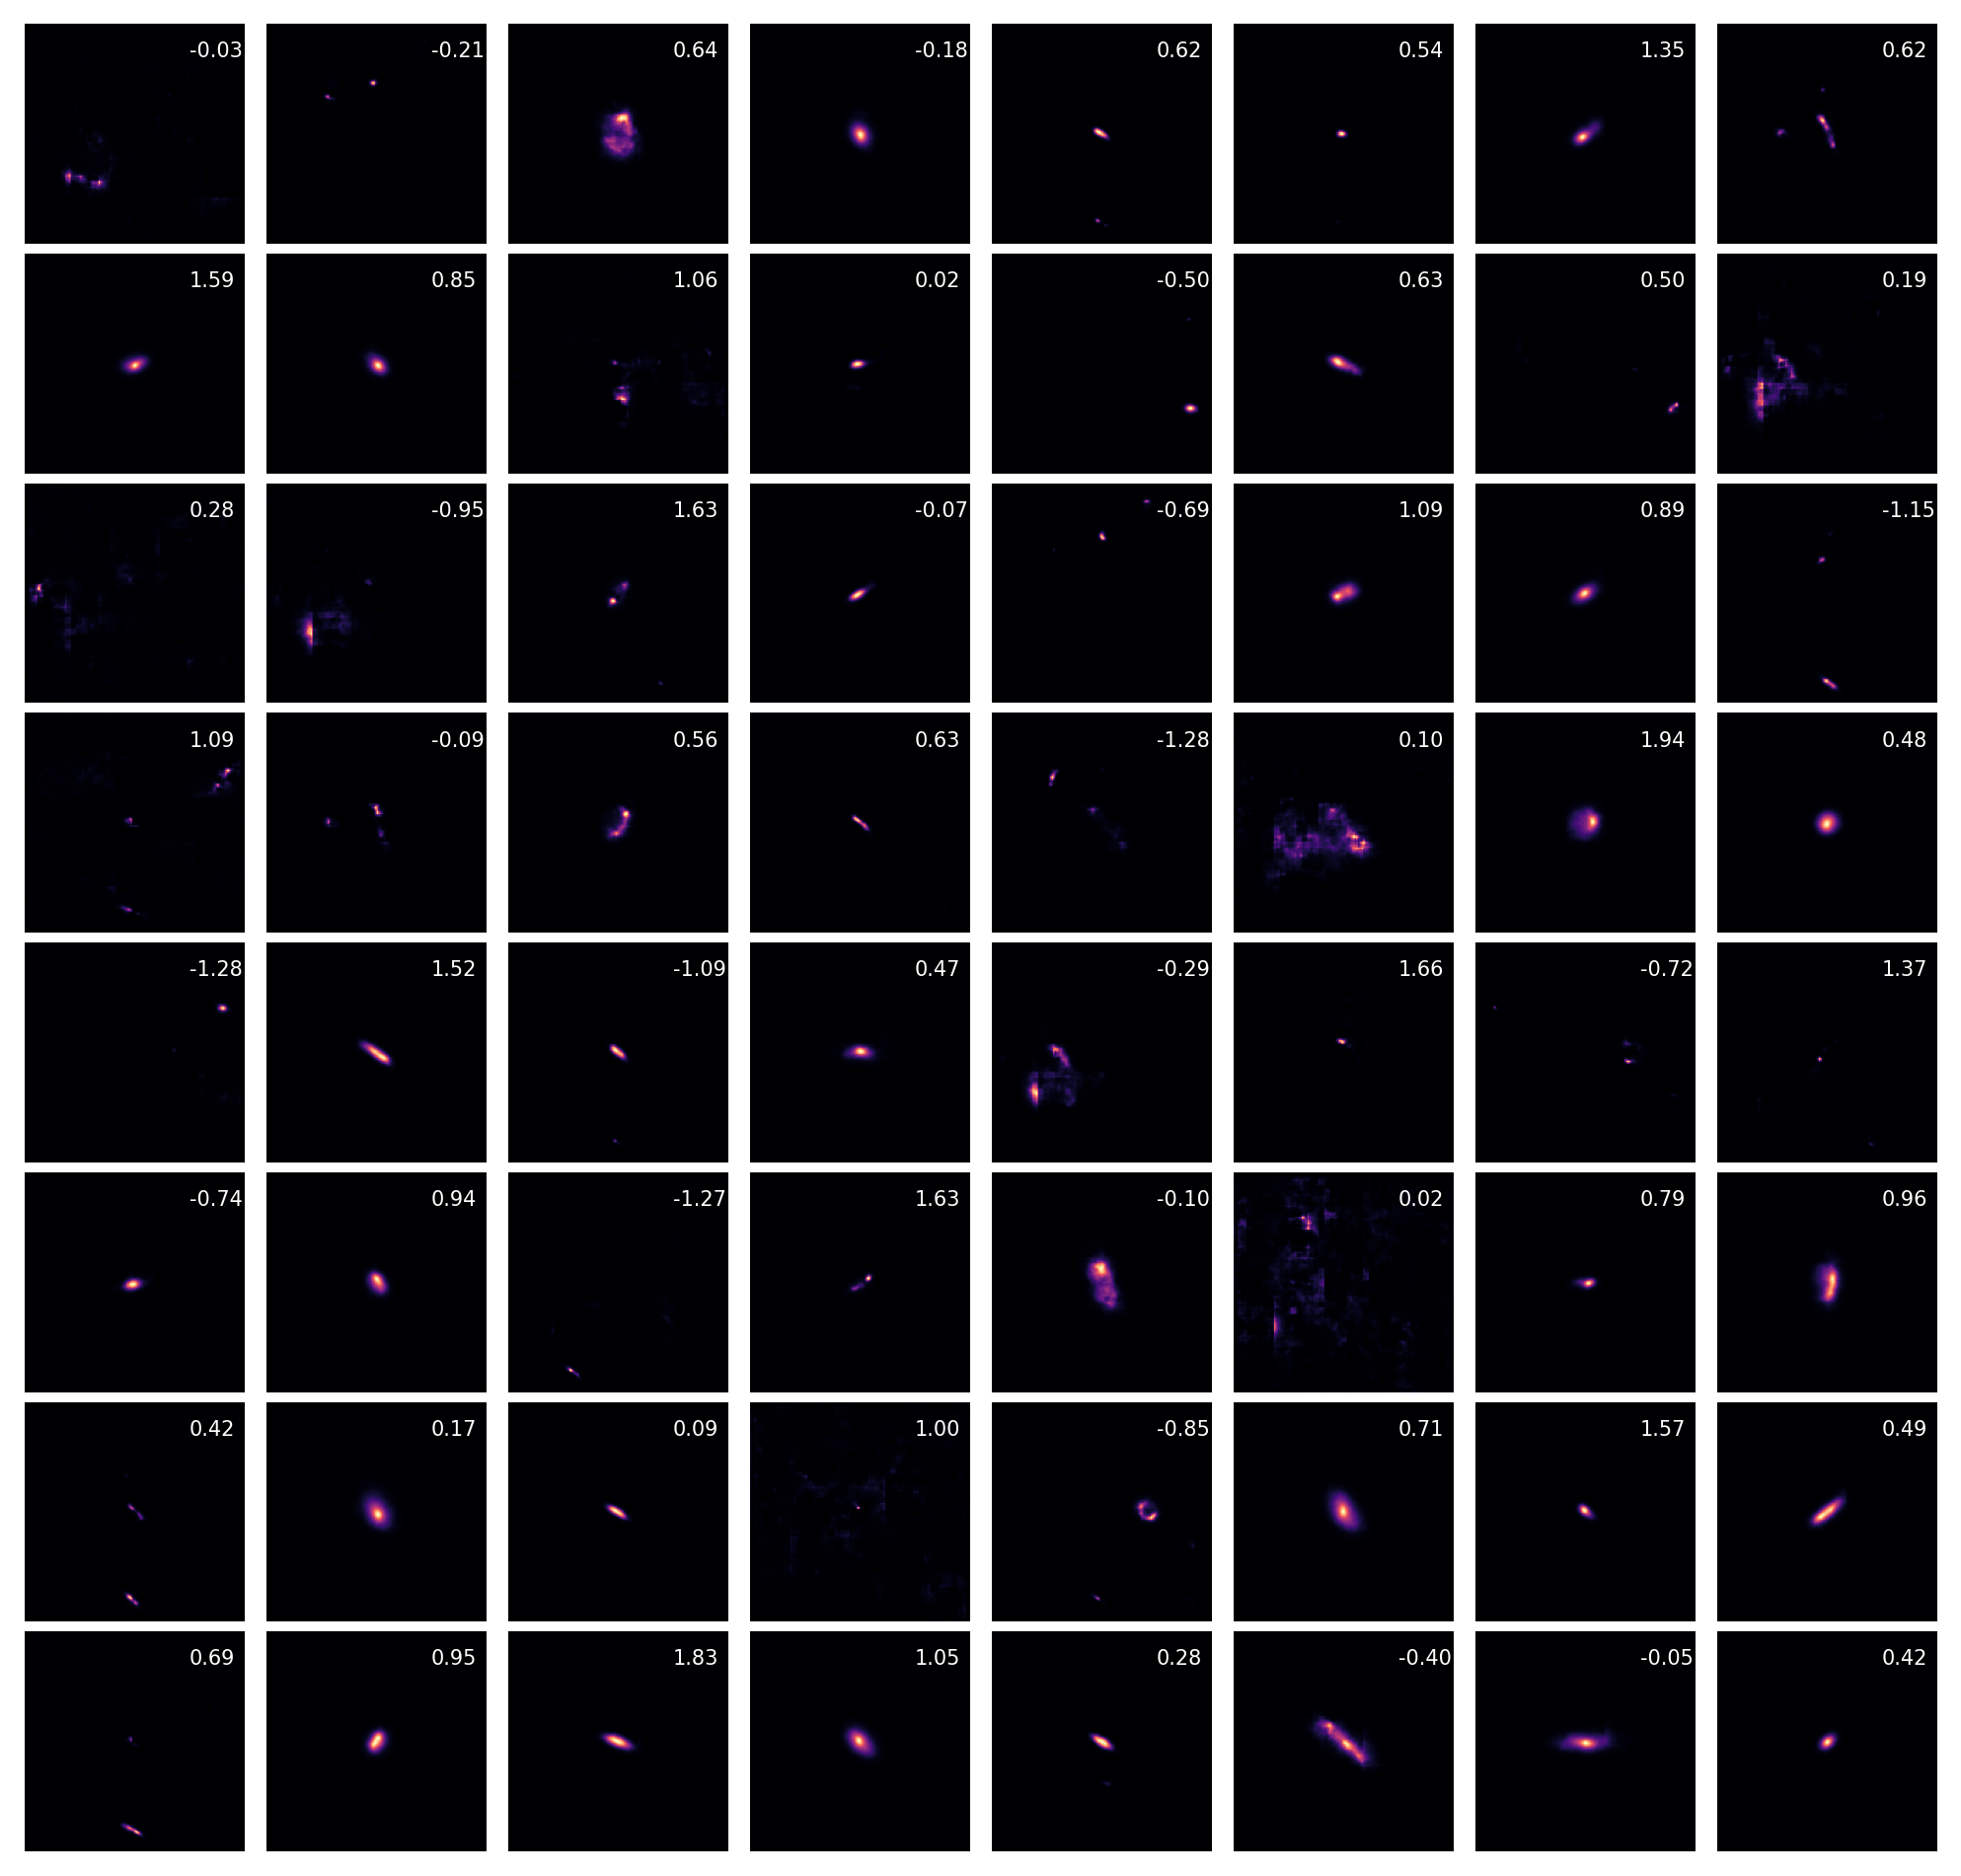

In [28]:
torch.manual_seed(0)
rows, cols = 8, 8
figure, axs = plt.subplots(rows, cols, figsize=(10,10))

for i in range(rows):
    for j in range(cols):
        z_generated = torch.normal(0, 1, size = (1,z_dim)).to(device)

        generated_galaxies, generated_cond = vae.decoder(z_generated)
        axs[i,j].imshow(generated_galaxies.detach().to('cpu').numpy().squeeze(), cmap = 'magma')
        axs[i,j].axis('off')
        axs[i,j].annotate(f"{generated_cond.item():.2f}", xy=(0.75, 0.85), xycoords = 'axes fraction', color = 'white', fontsize = 6)
        

plt.subplots_adjust(wspace = 0.1, hspace =-0.1)
plt.savefig("C:\\Users\\noedi\\Desktop\\Generation_CVAE1_beta0.1.jpeg")